# Hand-in 9 - AAA

#### António
#### Marco

## 1. Recurrent Neural Network Models

RNNs are **designed to operate upon sequences of data.**

Very effective for:

* **Natural language processing problems** where sequences of text are provided as input to the model. 
* Some success for **time series forecasting and speech recognition.**

Most popular RNN is **Long Short-Term Memory** (LSTM) network:

* can be used in a model to **accept a sequence of input data and make a prediction**, such as assign a class label or predict a numerical value **like the next value or values in the sequence.**

### Car sales predictions

We will use the car sales dataset to demonstrate an LSTM RNN for **univariate** time series forecasting.

This problem involves **predicting the number of car sales per month.**

* We will define a new function named **split_sequence() that will split the input sequence into windows of data appropriate for fitting a supervised learning model, like an LSTM.**

#### LSTMs expect each sample in the dataset to have two dimensions:

* the first is the **number of time steps** (in this case it is 5)
* the second is the **number of observations per time step** (in this case it is 1)


- Because it is a **regression type problem**, we will use a linear activation function (no activation function) in the output layer and **optimize the mean squared error loss function**. 
- We will also **evaluate the model using the mean absolute error (MAE) metric.**

In [ ]:
# lstm for time series forecasting
from numpy import sqrt
from numpy import asarray
from pandas import read_csv
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM


import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
            
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        
        X.append(seq_x)
        y.append(seq_y)
        
    return asarray(X), asarray(y)

In [ ]:
# load the dataset
path = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/monthly-car-sales.csv'

df = read_csv(path, header=0, index_col=0, squeeze=True)

In [ ]:
def ref_n(df, n_steps, n_test, n_runs = 5):
    '''
    Function to perform n_time runs of the RNN and provide the metrics
    '''
    
    results = pd.DataFrame(columns=['MSE', 'RMSE', 'MAE'])
    
    # retrieve the values
    values = df.values.astype('float32')
    
    # split into samples
    X, y = split_sequence(values, n_steps)

    # reshape into [samples, timesteps, features]
    X = X.reshape((X.shape[0], X.shape[1], 1))

    # split into train/test    
    X_train, X_test, y_train, y_test = X[:-n_test], X[-n_test:], y[:-n_test], y[-n_test:]
 
    
    for run in range(n_runs):
        print(f'Run{run+1}')
        # define model
        model = Sequential()
        model.add(LSTM(100, activation='relu', kernel_initializer='he_normal', input_shape=(n_steps,1)))
        model.add(Dense(50, activation='relu', kernel_initializer='he_normal'))
        model.add(Dense(50, activation='relu', kernel_initializer='he_normal'))
        model.add(Dense(1))


        # compile the model
        model.compile(optimizer='adam', loss='mse', metrics=['mae'])

        # fit the model
        history = model.fit(X_train, y_train, epochs=350, batch_size=32, verbose=0, validation_data=(X_test, y_test))

        # evaluate the model
        mse, mae = model.evaluate(X_test, y_test, verbose=0)
        
        results.loc[run,'MSE'] = mse 
        results.loc[run,'RMSE'] = sqrt(mse)
        results.loc[run,'MAE'] = mae

        
    
    results = results.reset_index().rename({'index':'run'},axis=1)
    
    results = results.append( pd.DataFrame([['mean', np.mean(results.MSE) ,
                                   np.mean(results.RMSE) , 
                                   np.mean(results.MAE)]], columns = results.columns))
    
    results = results.append( pd.DataFrame([['std', np.std(results.MSE) ,
                                   np.std(results.RMSE) , 
                                   np.std(results.MAE)]], columns = results.columns))
    
    results = results.reset_index(drop=True).style.apply(lambda row: ['background: lightgreen' if (set(['mean','std']).intersection(row.values)) 
                              else '' for i in row], axis=1)
        
    return results

## 1.1 Reference model

* We will frame the problem to **take a window of the last five months of data to predict the current month’s data.**
* We will use the **last 12 months of data as the test dataset.**

Thus, we have: 

* `n_steps` =  5
* `n_test` =  12

In [ ]:
results_ref = ref_n(df, n_steps = 5, n_test = 12, n_runs = 5)
results_ref

,run,MSE,RMSE,MAE
0,0,12398049.000000,3521.086338,2994.900391
1,1,11857195.000000,3443.427798,2712.870605
2,2,11477171.000000,3387.797367,2886.833984
3,3,12607152.000000,3550.655151,2998.071533
4,4,10757156.000000,3279.810360,2692.403076
5,mean,11819344.600000,3436.555403,2857.015918
6,std,605846.422971,88.654588,120.880926


In order to understand these results let's take a look at the distribution of the dataset

In [ ]:
df.describe()

count      108.000000
mean     14595.111111
std       4525.213913
min       5568.000000
25%      11391.250000
50%      14076.000000
75%      17595.750000
max      26099.000000
Name: Sales, dtype: float64

**Take-Aways:**

* Comparing with the mean the results correspond to having a 3000/14000*100 around a 20 percent error rate, which is not so bad



```
# Isto está formatado como código
```

## 1.2 Improving the model


### 1.2.1 Using 6 month window in the reference model

* Use a 6 month training window and compare it with the reference model.

Lets set `n_steps` = 6

In [ ]:
results_6 = ref_n(df, n_steps = 6, n_test=12)
results_6

,run,MSE,RMSE,MAE
0,0,8151865.500000,2855.147194,2266.058838
1,1,14771920.000000,3843.425555,3411.148438
2,2,13337024.000000,3651.989047,2835.530273
3,3,14396875.000000,3794.321415,2939.662842
4,4,14165069.000000,3763.651020,3091.650146
5,mean,12964550.700000,3581.706846,2908.810107
6,std,2238305.016044,336.559513,342.837497


**Comparing using a 5 vs 6 months windows:**

* There is not a significant improvement on the model when the training windows is 6 months.
* Probably the model has to be tweaked further in order to notice the difference, or maybe this dataset is to small for that to make an impact


### 1.2.2 Improving the model

* Improve the previous model and analyze the **learning curves to check the model convergence.** 

* The tutorial only splits the data into train and test sets. To properly evaluate these options, lets split the data into train, validation, and test sets.


**Lets also consider:**

* normalization of data
* dropout 
* batch normalization
* early stopping

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.python.framework import ops
from keras import backend as K


def improve_n(df, n_steps, n_val, n_test, 
              epochs = 50000, 
              normalize = False, 
              dropout = 0, 
              batch_norm = False,
              early_stop = False, 
              patience = 20,
              n_runs = 5,
              learning_rate = 0.001,
              LSTM_units = 100,
              Dense_units = 50,
              test_score = False):
    '''
    Function to perform n_time runs of the RNN and provide the metrics
    
    inputs:
    df (pandas.DataFrame): dataframe
    n_step (int): number of months to consider for training
    n_val (int): number of months to consider for the validation set
    n_test (int): number of months to consider for the test set
    epochs (int): number of max epochs
    normalize (bool): whether to apply normalization to the data before starting the training process
    dropout (int): [0,1] fraction of the input units to drop from the previous layer to avoid overfitting
    batch_norm (bool): whether to apply bath normalization
    early_stop (bool): whether to apply early stop call back or not
    patience (int):  number of epochs to observed overfitting before taking action. Only considered if early_stop = True
    n_runs (int): number of runs for the average and standard deviation calculations
    '''
    
    results = pd.DataFrame(columns=['epochs','MSE', 'RMSE', 'MAE'])
    
    # retrieve the values
    values = df.values.astype('float32')

#     if normalize:
#         values = StandardScaler().fit_transform(pd.DataFrame(values))
#         values = np.concatenate(values)

    # split into samples
    X, y = split_sequence(values, n_steps)

    # reshape into [samples, timesteps, features]
    X = X.reshape((X.shape[0], X.shape[1], 1))

    # split into train/test    
    X_train, X_test, y_train, y_test = X[:-n_test], X[-n_test:], y[:-n_test], y[-n_test:]
    
    # split the train into train/val    
    X_val, y_val = X_train[-n_val:], y_train[-n_val:]
    X_train, y_train = X_train[:-n_val], y_train[:-n_val]
    if normalize:
        print('Normalization stats:\n Mean:',X_train.mean(),'Std_dev',X_train.std())
        X_mean = X_train.mean() 
        X_std = X_train.std()

        X_train = (X_train - X_mean) / X_std
        X_val = (X_val - X_mean) / X_std
        X_test = (X_test - X_mean) / X_std

        y_train = (y_train - X_mean) / X_std
        y_val = (y_val - X_mean) / X_std
        y_test = (y_test - X_mean) / X_std

    
    # configure early stopping
    es = EarlyStopping(monitor='val_loss', patience=patience)
    
    fig, axes = plt.subplots(1, n_runs, figsize=(7*n_runs, 6) )
    
    for run, ax in zip( range(n_runs), axes.flat):
        # define model
        model = Sequential()
        model.add(LSTM(LSTM_units, activation='relu', kernel_initializer='he_normal', input_shape=(n_steps,1)))
        model.add(Dropout(dropout))
        
        if batch_norm:
            model.add(BatchNormalization())
            
        model.add(Dense(Dense_units, activation='relu', kernel_initializer='he_normal'))
        model.add(Dropout(dropout))
        
        if batch_norm:
            model.add(BatchNormalization())  
            
        model.add(Dense(Dense_units, activation='relu', kernel_initializer='he_normal'))

        model.add(Dense(1))
      
        
        # compile the model
        optimizer = Adam(lr=learning_rate)
        model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

        # fit the model
        if early_stop:
            history = model.fit(X_train, y_train, epochs=epochs, batch_size=32, verbose=0, 
                                validation_data=(X_val, y_val), callbacks=[es])
        else:
            history = model.fit(X_train, y_train, epochs=epochs, batch_size=32, verbose=0, 
                                validation_data=(X_val, y_val))

        if test_score:
          #make predictions for test score
          y_pred = model.predict(X_test)
          mse = mean_squared_error(y_test, y_pred)
          mae = mean_absolute_error(y_test, y_pred)
        else:
          # evaluate the model
          mse, mae = model.evaluate(X_val, y_val, verbose=0)
        
        
        # make prediction for test score
        
        
        results.loc[run, 'epochs'] = len(history.history['loss'])
        results.loc[run,'MSE'] = mse 
        results.loc[run,'RMSE'] = sqrt(mse)
        results.loc[run,'MAE'] = mae
        
        #print('MSE: %.3f, RMSE: %.3f, MAE: %.3f' % (mse, sqrt(mse), mae))

        
        # plot learning curves
        ax.set_title(f'Run {run} Learning Curves')
        ax.set_xlabel('Epoch')
        ax.set_ylabel('MSE')
        ax.plot(history.history['loss'], label='train')
        ax.plot(history.history['val_loss'], label='validation')
        ax.legend()
        #ax.set_ylim([0,1e8])

        #clear state
        K.clear_session()
        ops.reset_default_graph()
        
    
    results = results.reset_index().rename({'index':'run'},axis=1)
    
    results = results.append( pd.DataFrame([['mean', np.mean(results.epochs),
                                             np.mean(results.MSE) ,
                                             np.mean(results.RMSE) , 
                                             np.mean(results.MAE)]], columns = results.columns))
    
    results = results.append( pd.DataFrame([['std', np.std(results.epochs),
                                             np.std(results.MSE) ,
                                             np.std(results.RMSE) , 
                                             np.std(results.MAE)]], columns = results.columns))
    
    results = results.reset_index(drop=True).style.apply(lambda row: ['background: lightgreen' if (set(['mean','std']).intersection(row.values)) 
                              else '' for i in row], axis=1)
    
    
        
    return results

 Lets analyze the learning curves to check the model convergence with the same epochs = 350 we've been using:

,run,epochs,MSE,RMSE,MAE
0,0,350,7560121.500000,2749.567511,2329.894531
1,1,350,13782715.000000,3712.507912,3014.206787
2,2,350,19616746.000000,4429.079588,3590.107422
3,3,350,10298707.000000,3209.159859,2747.696533
4,4,350,6608218.500000,2570.645541,2174.509521
5,mean,350.000000,11573301.600000,3334.192083,2771.282959
6,std,0.000000,4319736.903394,616.755460,462.061339


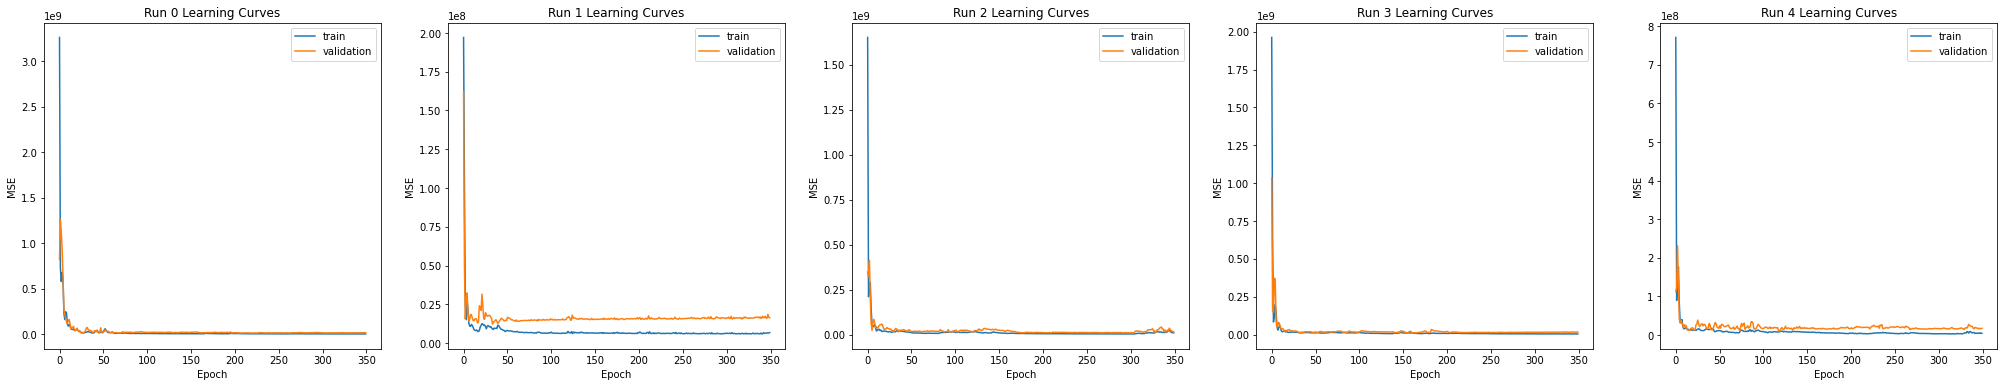

In [ ]:
improve_n(df, n_steps = 6, n_val = 12, n_test = 12, 
              epochs = 350, 
              normalize = False, 
              dropout = 0, 
              batch_norm = False,
              early_stop = False, 
              patience = 20,
              n_runs = 5,
              learning_rate = 0.001)

* Depending on initial conditions the problem has very different convergence points. That probaby means that the learning rate is too low because the model gets stuck in a local minima before converging. Let's bump up the learning rate and repeat the process.



,run,epochs,MSE,RMSE,MAE
0,0,350,9099371.000000,3016.516368,2549.169189
1,1,350,7211320.000000,2685.390102,2277.379395
2,2,350,5262016.500000,2293.908564,2016.130493
3,3,350,13049925.000000,3612.467993,2867.443604
4,4,350,8220866.500000,2867.205347,2392.300537
5,mean,350.000000,8568699.800000,2895.097675,2420.484644
6,std,0.000000,2354450.168941,394.872610,258.556170


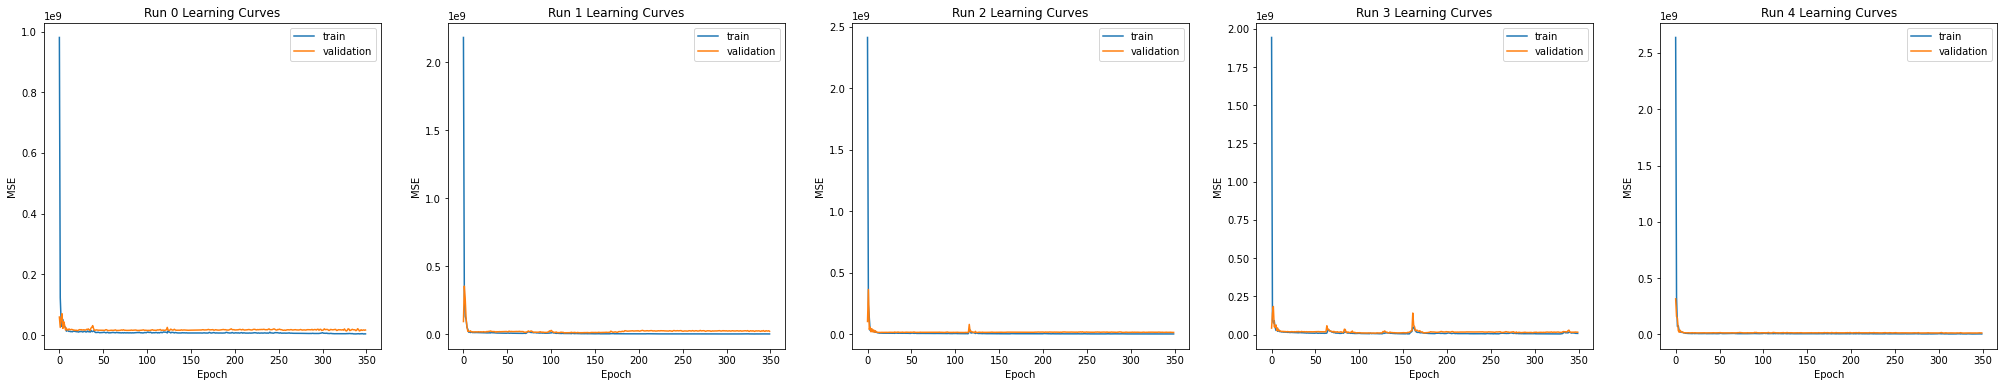

In [ ]:
improve_n(df, n_steps = 6, n_val = 12, n_test = 12, 
              epochs = 350, 
              normalize = False, 
              dropout = 0, 
              batch_norm = False,
              early_stop = False, 
              patience = 20,
              n_runs = 5,
              learning_rate = 0.01)

**Take-Aways:**

* The results are already much better.

* The model was converging before, as one can see for the plots. This means that 350 epochs were sufficient for the model to converge and probably they are too much as it can be seen that after 10 epochs or so the results don't change.

Lets now implement the improvements one by one.

#### 1.2.2.1 Normalization

The mean and standard deviation should only be computed using the training data so that the models have no access to the values in the validation and test sets.

Normalization stats:
 Mean: 13841.333 Std_dev 4370.644


,run,epochs,MSE,RMSE,MAE
0,0,100,0.668010,0.817319,0.571660
1,1,100,0.420943,0.648802,0.541723
2,2,100,0.427667,0.653962,0.509180
3,3,100,0.658817,0.811675,0.635793
4,4,100,0.609615,0.780778,0.646584
5,mean,100.000000,0.557010,0.742507,0.580988
6,std,0.000000,0.100579,0.068880,0.048462


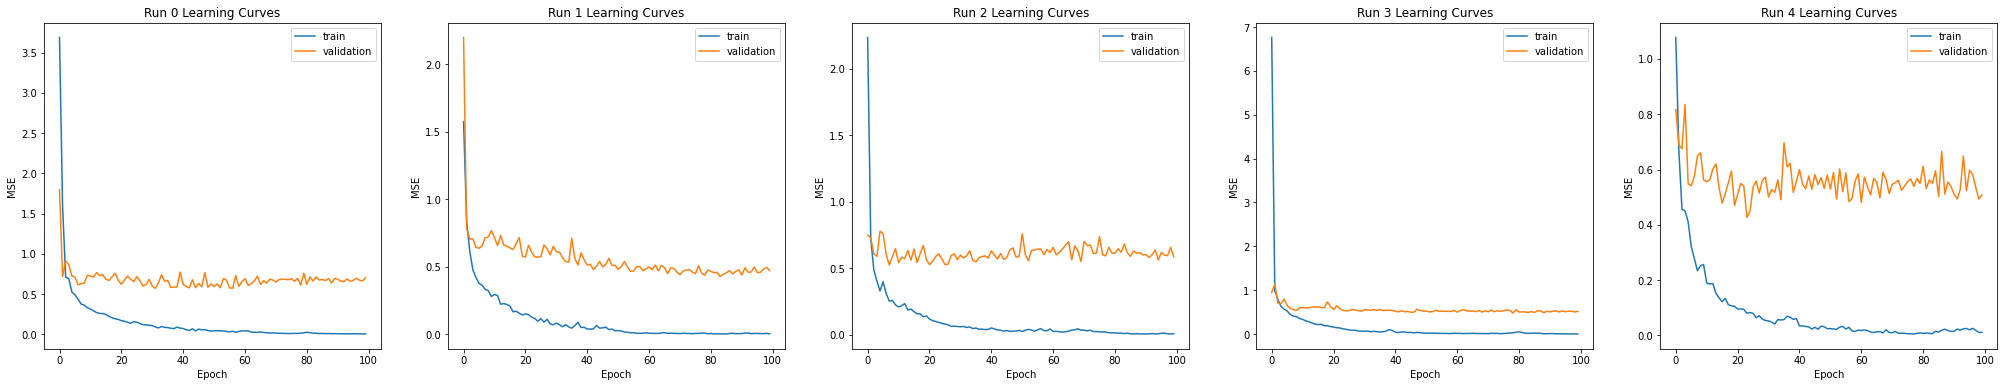

In [ ]:
norm = improve_n(df, n_steps = 6, n_val = 12, n_test = 12, 
              epochs = 100, 
              normalize = True, 
              dropout = 0, 
              batch_norm = False,
              early_stop = False, 
              patience = 20,
              n_runs = 5,
              learning_rate = 0.007)
norm

**Take-Aways:**

* If we rescale the RMSE by multiplying by the standard deviation of the original training set we get 4370\*0.8 = 3233 +- 235 and a MAE of 4370\*0.6 = 2534 +- 253, so the results did not seem to improve.


#### 1.2.2.2 Dropout

Dropout is a clever regularization method that **reduces overfitting of the training dataset** and makes the model more robust. Note that as the dropout is increased so is the learning rate

Lets try with different dropout parameters in [0.1, 0.3, 0.5]

,run,epochs,MSE,RMSE,MAE
0,0,100,16713475.000000,4088.211712,3069.428467
1,1,100,18728592.000000,4327.654330,3190.036133
2,2,100,18991114.000000,4357.879530,3551.163818
3,3,100,24477066.000000,4947.430242,4115.146973
4,4,100,13561175.000000,3682.550068,3007.500244
5,mean,100.000000,18494284.400000,4280.745176,3386.655127
6,std,0.000000,3255822.114501,375.838103,374.346917


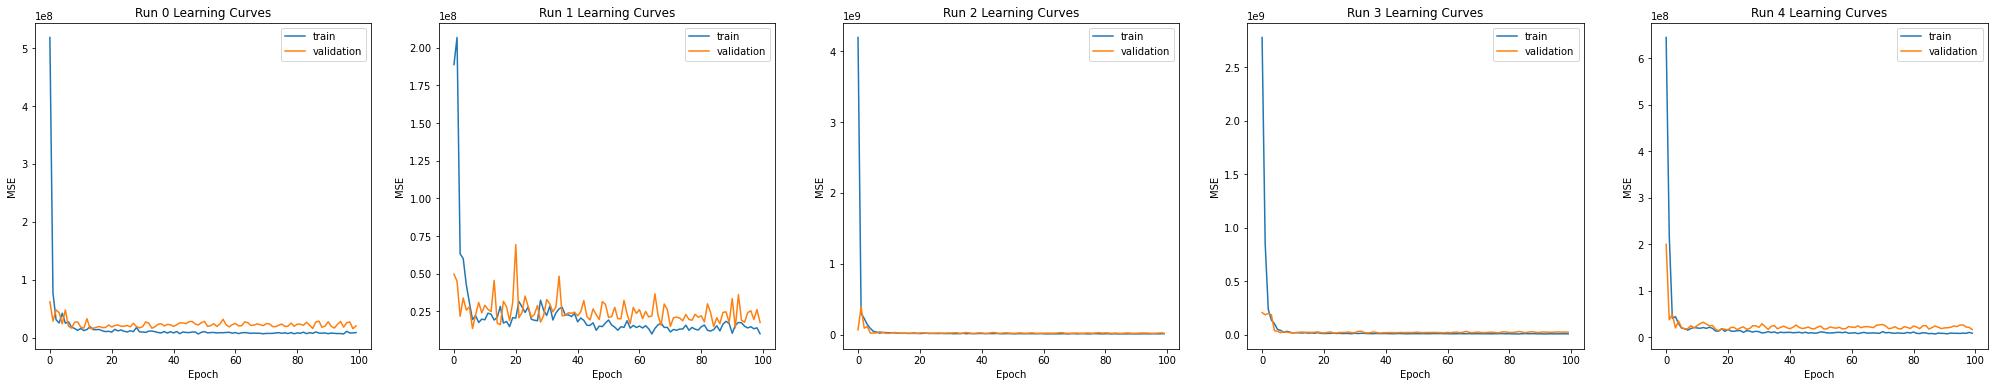

In [ ]:
drop_10 = improve_n(df, n_steps = 6, n_val = 12, n_test = 12, 
              epochs = 100, 
              normalize = False, 
              dropout = 0.1, 
              batch_norm = False,
              early_stop = False, 
              patience = 20,
              n_runs = 5,
              learning_rate = 0.01)

drop_10

,run,epochs,MSE,RMSE,MAE
0,0,100,61441908.000000,7838.488885,6527.460449
1,1,100,51802224.000000,7197.376189,6604.825684
2,2,100,56168180.000000,7494.543348,6925.116699
3,3,100,72274072.000000,8501.415882,7870.771484
4,4,100,82443616.000000,9079.846695,8471.448242
5,mean,100.000000,64826000.000000,8022.334200,7279.924512
6,std,0.000000,10180723.919543,624.602532,697.218058


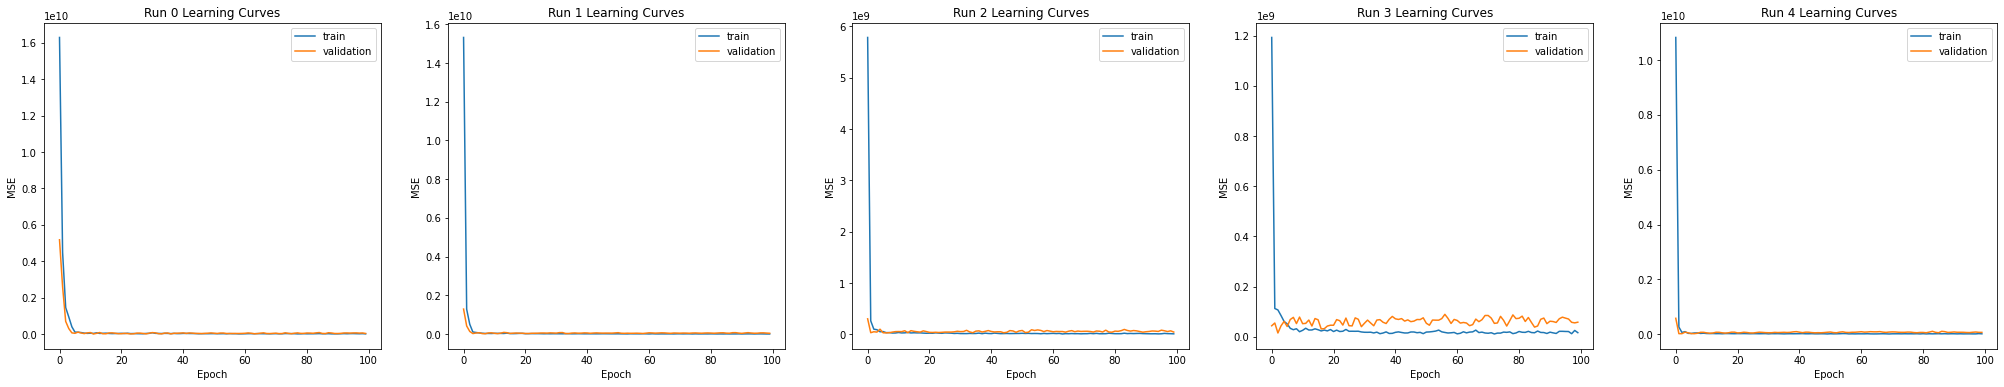

In [ ]:
drop_30 = improve_n(df, n_steps = 6, n_val = 12, n_test = 12, 
              epochs = 100, 
              normalize = False, 
              dropout = 0.3, 
              batch_norm = False,
              early_stop = False, 
              patience = 20,
              n_runs = 5,
              learning_rate = 0.03)

drop_30

,run,epochs,MSE,RMSE,MAE
0,0,100,94222360.000000,9706.820283,9211.397461
1,1,100,140715200.000000,11862.343782,11369.051758
2,2,100,220535424.000000,14850.435145,14421.625000
3,3,100,161228976.000000,12697.597253,12231.680664
4,4,100,204359408.000000,14295.433117,13812.067383
5,mean,100.000000,164212273.600000,12682.525916,12209.164453
6,std,0.000000,41319265.501664,1674.766151,1691.014623


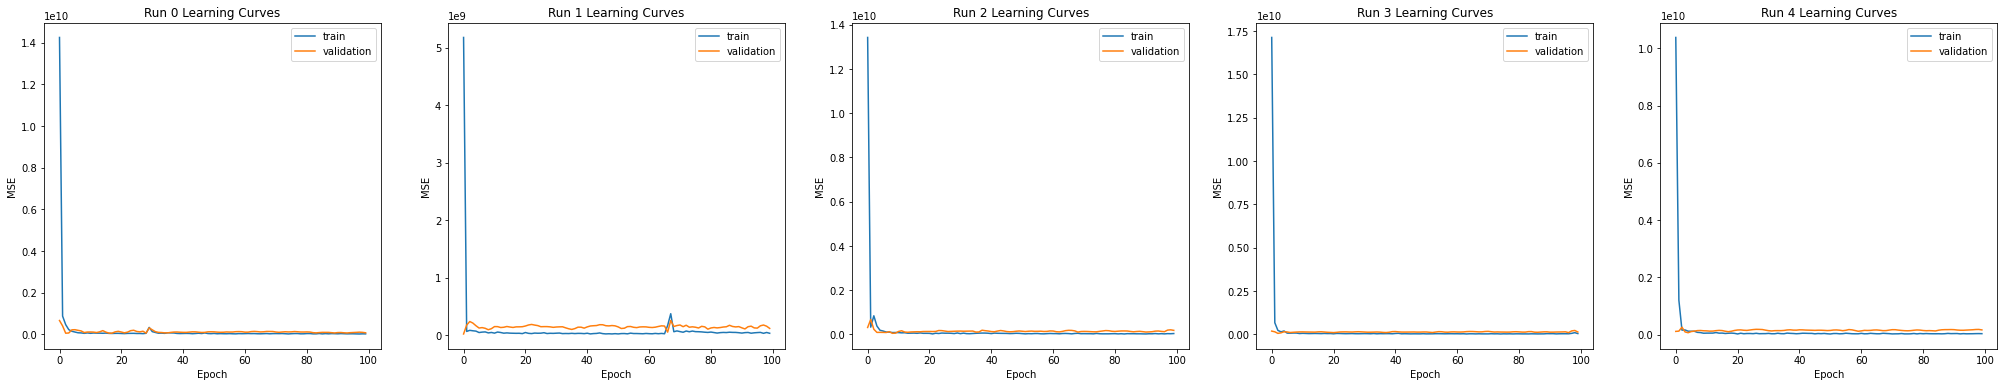

In [ ]:
drop_50 = improve_n(df, n_steps = 6, n_val = 12, n_test = 12, 
              epochs = 100, 
              normalize = False, 
              dropout = 0.5, 
              batch_norm = False,
              early_stop = False, 
              patience = 20,
              n_runs = 5,
              learning_rate = 0.03)

drop_50

* The fact that the results get worse as dropout increases suggests that maybe there are not enough neurons to train it properly. Let's try to increase that number.

,run,epochs,MSE,RMSE,MAE
0,0,100,37056956.000000,6087.442484,5208.187500
1,1,100,35312972.000000,5942.471876,5183.419922
2,2,100,33865492.000000,5819.406499,5001.627930
3,3,100,33091698.000000,5752.538396,4886.675293
4,4,100,34098968.000000,5839.432164,4880.504395
5,mean,100.000000,34685217.200000,5888.258284,5032.083008
6,std,0.000000,1263207.688989,106.581663,128.428090


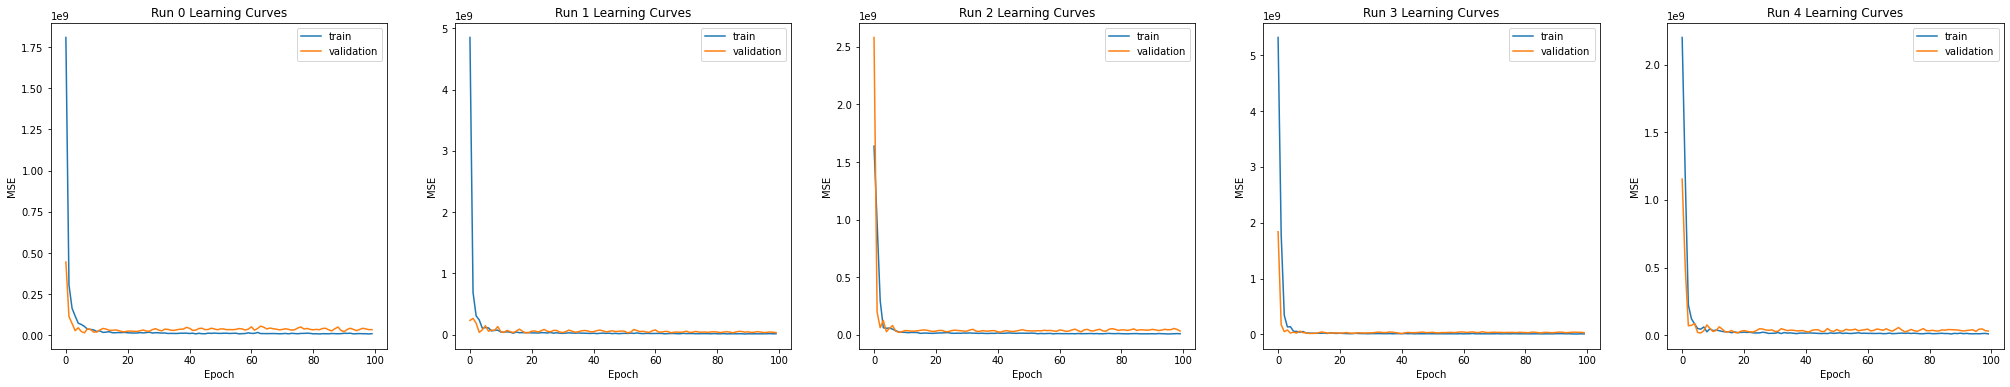

In [ ]:
drop_20 = improve_n(df, n_steps = 6, n_val = 12, n_test = 12, 
              epochs = 100, 
              normalize = False, 
              dropout = 0.2, 
              batch_norm = False,
              early_stop = False, 
              patience = 20,
              n_runs = 5,
              learning_rate = 0.007,
              LSTM_units=200,
              Dense_units = 100)

drop_20

**Take-Aways:**
* Dropout did not improve results.
* Increasing network sizes did not improve results
* Possibly putting dropout in different layers might improve results
* Combinning dropout with other techniques might also work



#### 1.2.2.3 Batch Normalization

Batch normalization is a technique for training very deep neural networks that standardizes the inputs to a layer for each mini-batch. This has the effect of stabilizing the learning process and dramatically reducing the number of training epochs required to train deep networks.

When combining it with dropout, dropout is meant to block information from certain neurons completely to make sure the neurons do not co-adapt. So, **the batch normalization has to be after dropout otherwise you are passing information through normalization statistics.**


Normalization stats:
 Mean: 13841.333 Std_dev 4370.644


,run,epochs,MSE,RMSE,MAE
0,0,200,0.269922,0.519540,0.422968
1,1,200,0.298100,0.545986,0.446852
2,2,200,0.395485,0.628876,0.488869
3,3,200,0.255827,0.505794,0.401279
4,4,200,0.329830,0.574309,0.412419
5,mean,200.000000,0.309833,0.554901,0.434478
6,std,0.000000,0.045430,0.039980,0.028380


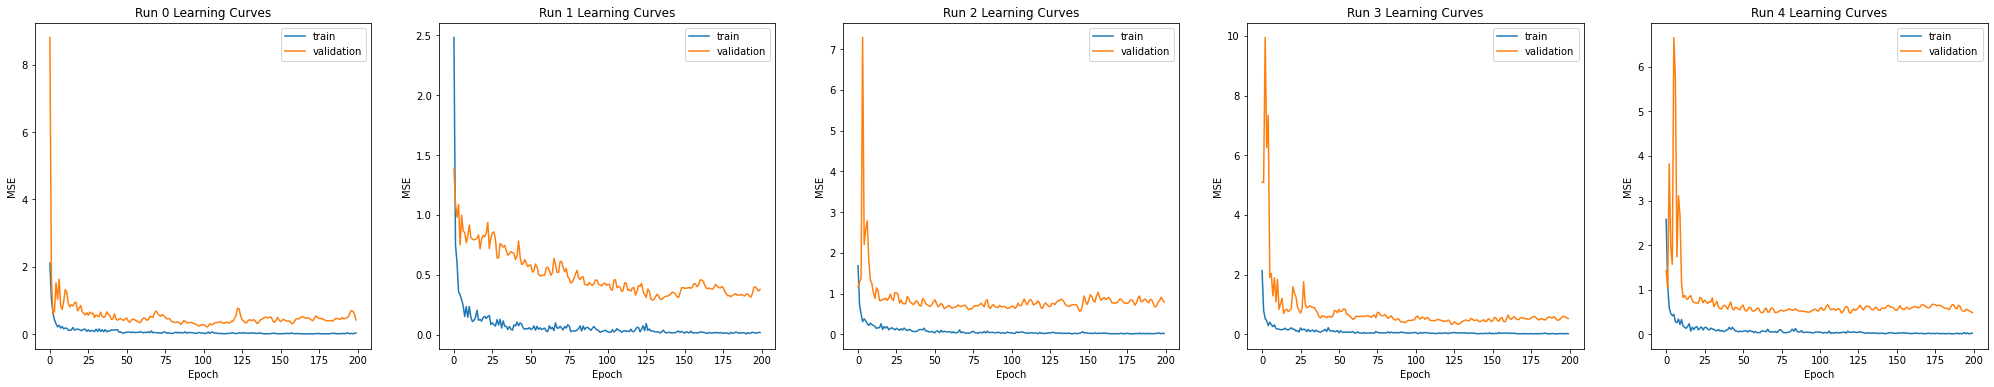

In [ ]:
batch = improve_n(df, n_steps = 6, n_val = 12, n_test = 12, 
              epochs = 200, 
              normalize = True, 
              dropout = 0, 
              batch_norm = True,e
              early_stop = False, 
              patience = 20,
              n_runs = 5,
              learning_rate=0.01)

batch

**Take-Aways:**

* These are the best results yet and they correspond to RMSE of 2400

#### 1.2.2.4 Early stop

_Too little training and the model is underfit; too much training and the model overfits the training dataset. Both cases result in a model that is less effective than it could be._


In a way to **avoid overfitting**, we will monitor the loss on the training dataset using the validation set. As soon as the validation set starts to show signs of overfitting, the training process will be stopped after a defined number of epochs that showed signs of overfitting.

_This allows you to set the number of epochs to a large number and be confident that training will end as soon as the model starts overfitting._

Lets try the Early stop with different `patience` - the number of epochs that show overfitting before stopping the training.

,run,epochs,MSE,RMSE,MAE
0,0,8,21804798.000000,4669.560793,3390.853760
1,1,14,14316408.000000,3783.702948,3082.043701
2,2,16,18543022.000000,4306.160935,3369.814209
3,3,36,13775800.000000,3711.576484,2792.804688
4,4,22,21533558.000000,4640.426489,3300.665283
5,mean,19.200000,17994717.200000,4222.285530,3187.236328
6,std,8.687155,3127031.845463,373.075175,205.873212


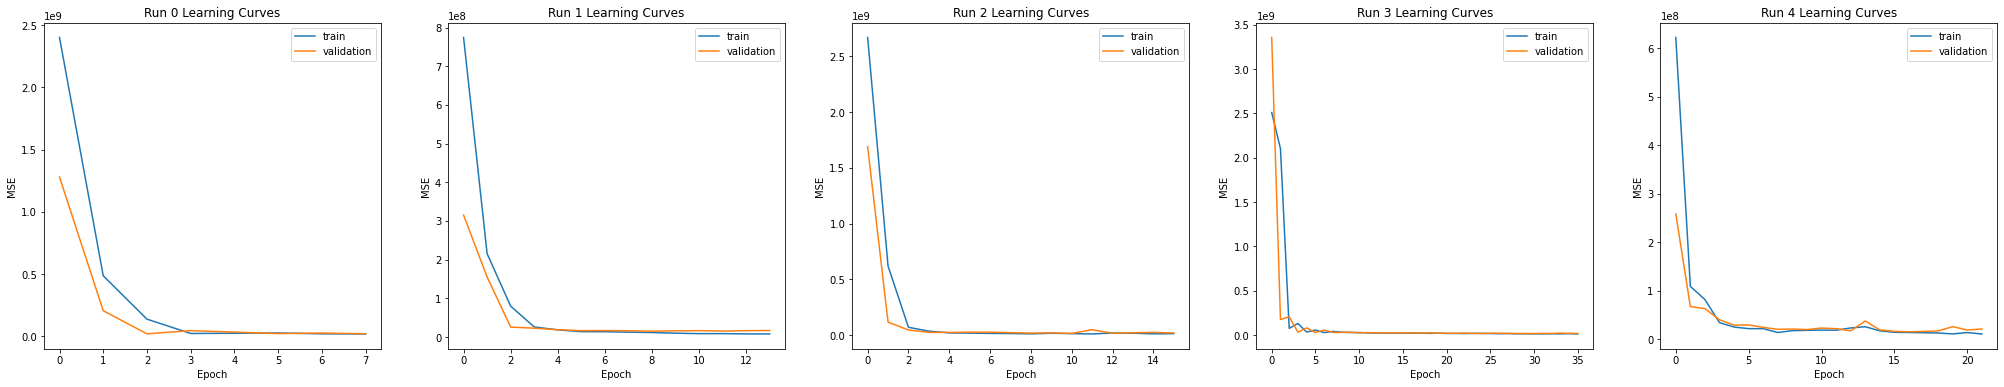

In [ ]:
es_5 = improve_n(df, n_steps = 6, n_val = 12, n_test = 12, 
              epochs = 5000, 
              normalize = False, 
              dropout = 0, 
              batch_norm = False,
              early_stop = True, 
              patience = 5,
              n_runs = 5,
              learning_rate = 0.01)

es_5

,run,epochs,MSE,RMSE,MAE
0,0,29,14282531.000000,3779.223598,2935.989502
1,1,38,13139417.000000,3624.833375,2951.594971
2,2,32,15484132.000000,3934.988183,3305.535889
3,3,26,15522171.000000,3939.818651,3019.982666
4,4,143,12082709.000000,3476.019131,2775.698486
5,mean,53.600000,14102192.000000,3750.976588,2997.760303
6,std,40.965839,1222283.925477,164.232152,158.365592


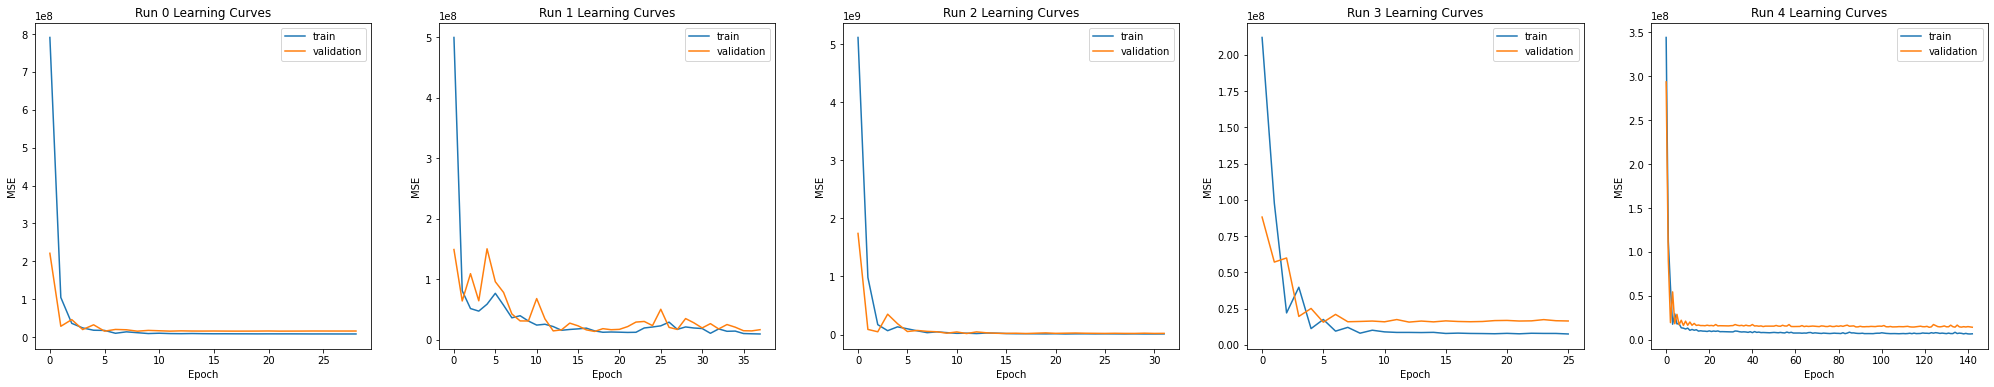

In [ ]:
es_20 = improve_n(df, n_steps = 6, n_val = 12, n_test = 12, 
              epochs = 5000, 
              normalize = False, 
              dropout = 0, 
              batch_norm = False,
              early_stop = True, 
              patience = 20,
              n_runs = 5,
              learning_rate = 0.01)

es_20

,run,epochs,MSE,RMSE,MAE
0,0,91,12324133.000000,3510.574454,2930.725586
1,1,65,15136056.000000,3890.508450,3124.451172
2,2,108,18545774.000000,4306.480466,3723.404297
3,3,59,12137644.000000,3483.912169,2668.059326
4,4,65,14114355.000000,3756.907638,2868.631836
5,mean,77.600000,14451592.400000,3789.676635,3063.054443
6,std,17.161973,2130140.181380,273.775150,329.434795


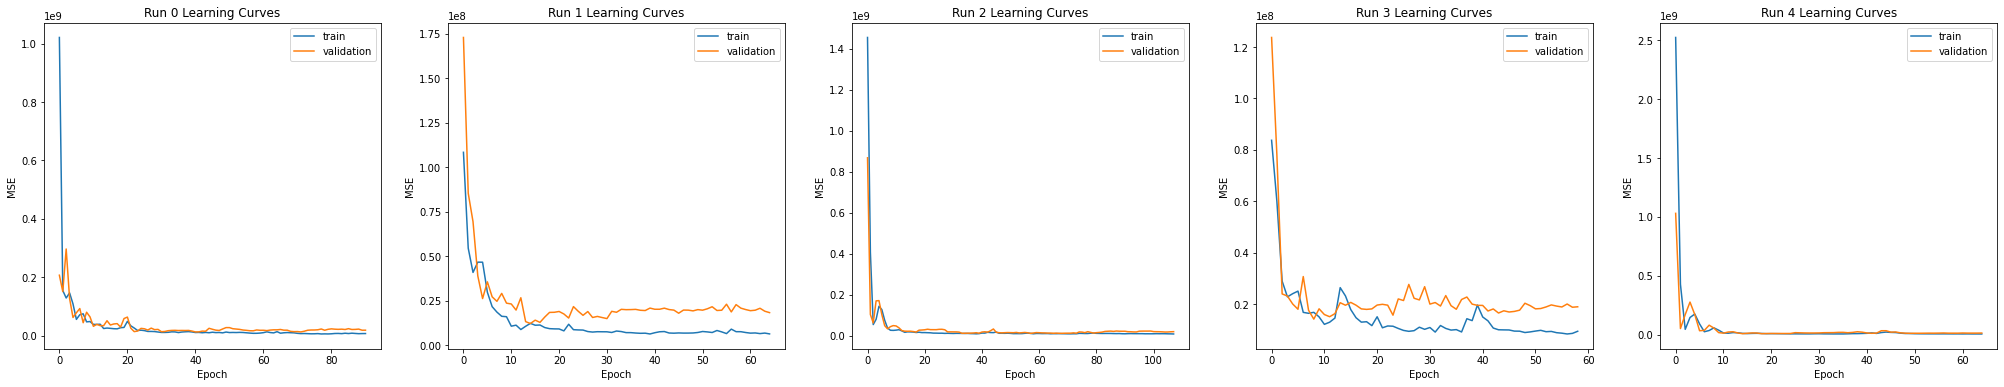

In [ ]:
es_50 = improve_n(df, n_steps = 6, n_val = 12, n_test = 12, 
              epochs = 5000, 
              normalize = False, 
              dropout = 0, 
              batch_norm = False,
              early_stop = True, 
              patience = 50,
              n_runs = 5,
              learning_rate = 0.01)

es_50

,run,epochs,MSE,RMSE,MAE
0,0,222,10351240.000000,3217.334300,2738.852783
1,1,186,6270427.500000,2504.082167,2013.601562
2,2,202,13657675.000000,3695.629175,3038.304688
3,3,118,13683565.000000,3699.130303,2866.324219
4,4,111,14567744.000000,3816.771410,2832.281982
5,mean,167.800000,11706130.300000,3386.589471,2697.873047
6,std,41.119339,2807436.563007,444.542886,324.613120


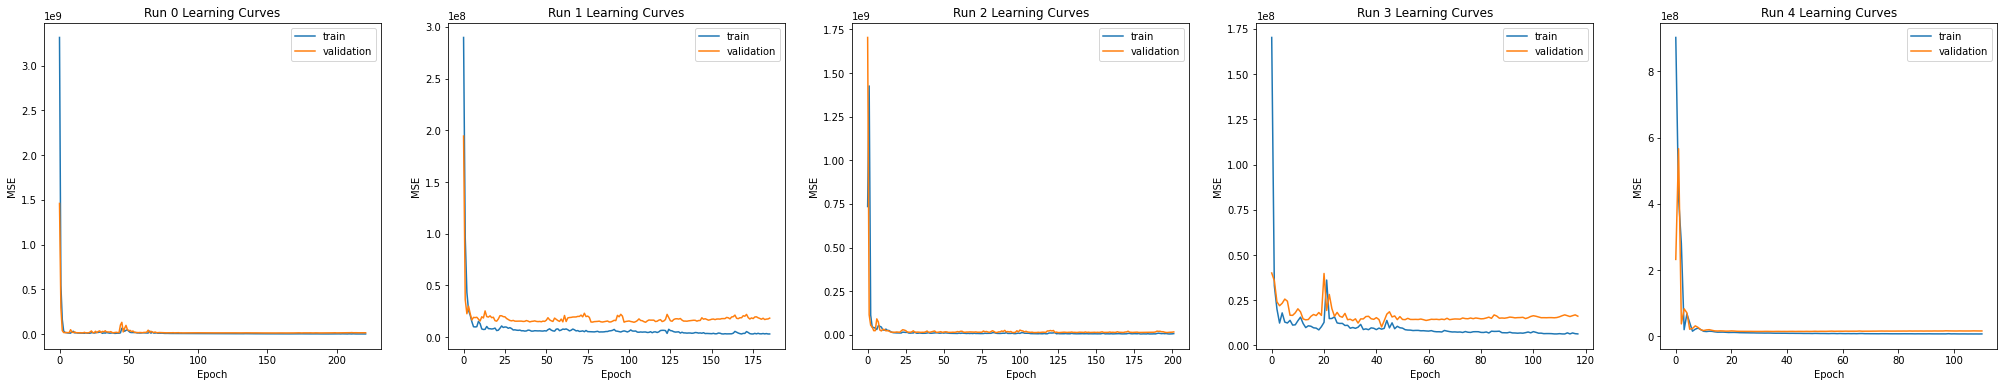

In [ ]:
es_75 = improve_n(df, n_steps = 6, n_val = 12, n_test = 12, 
              epochs = 5000, 
              normalize = False, 
              dropout = 0, 
              batch_norm = False,
              early_stop = True, 
              patience = 75,
              n_runs = 5,
              learning_rate = 0.01)

es_75

,run,epochs,MSE,RMSE,MAE
0,0,419,7832682.000000,2798.692909,2289.271240
1,1,159,9589203.000000,3096.643828,2513.948975
2,2,122,9856596.000000,3139.521620,2556.466553
3,3,147,8279570.500000,2877.424282,2441.641602
4,4,160,14192669.000000,3767.315888,3100.480225
5,mean,201.400000,9950144.100000,3135.919705,2580.361719
6,std,100.104279,2058013.166048,311.115869,251.489506


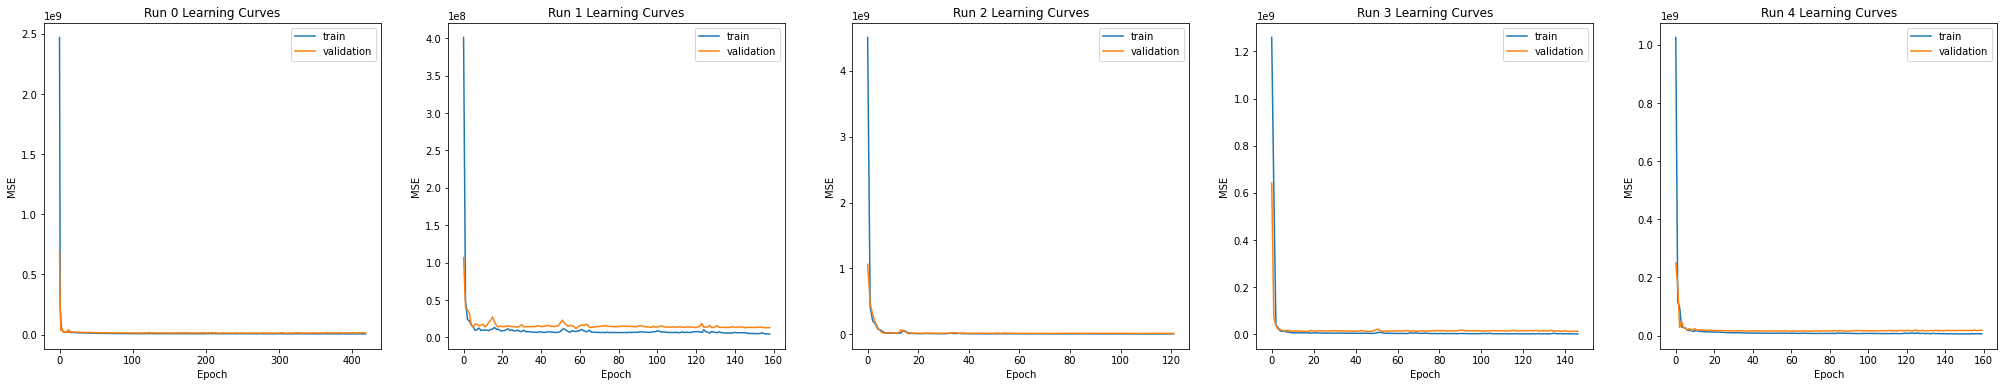

In [ ]:
es_100 = improve_n(df, n_steps = 6, n_val = 12, n_test = 12, 
              epochs = 5000, 
              normalize = False, 
              dropout = 0, 
              batch_norm = False,
              early_stop = True, 
              patience = 100,
              n_runs = 5,
              learning_rate = 0.01)

es_100

**Take-Aways:**

* The number of epochs is now possible to be higher than before becuase we have a way to stop the training process
* As the patience rises, the MAE and RMSE goes lower and lower
* The best was `patience` = 100 epochs

#### 1.2.2.5 Using all improvements

Now lets combine all the improvements we tried with the "best parameters" found. 

* Dropout was test in combination with the other improvements, but never improved results, so it will be set to 0.
* `patience` will be set to 100 epochs with `early_stop` set to True
* `batch_norm` will beset to True
* `normalize` will beset to True

Normalization stats:
 Mean: 13841.333 Std_dev 4370.644


,run,epochs,MSE,RMSE,MAE
0,0,226,0.405178,0.636536,0.516521
1,1,294,0.289991,0.538508,0.453495
2,2,229,0.237664,0.487508,0.376601
3,3,293,0.311326,0.557966,0.420731
4,4,164,0.455231,0.674708,0.548622
5,mean,241.200000,0.339878,0.579045,0.463194
6,std,44.367405,0.072252,0.061810,0.057063


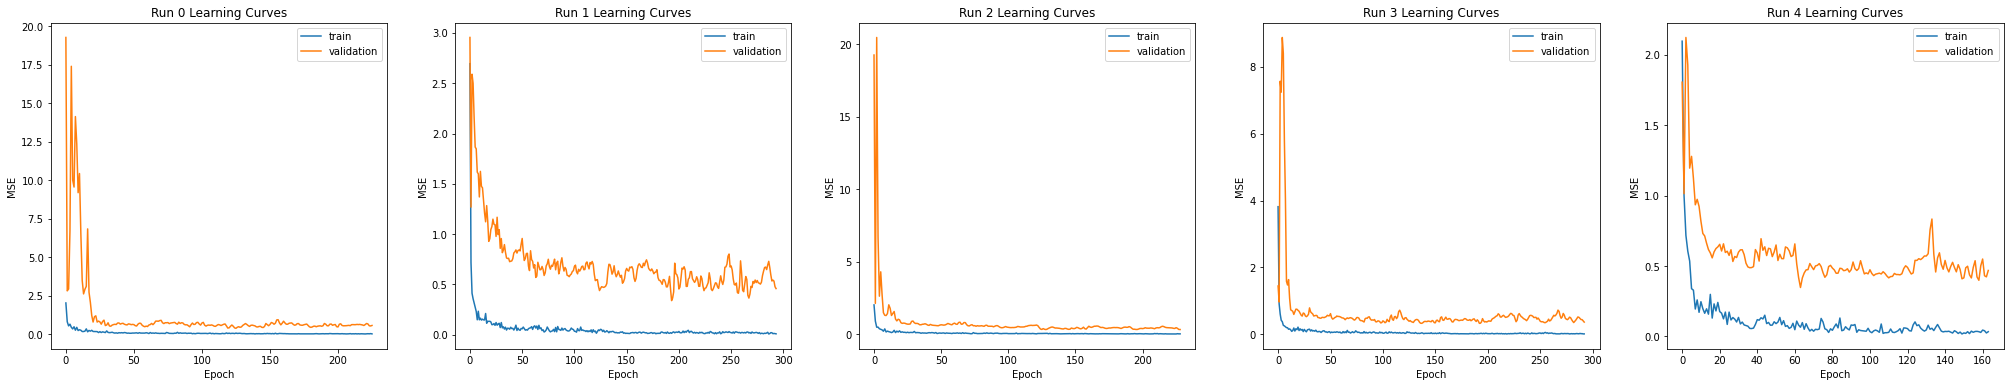

In [ ]:
improved = improve_n(df, n_steps = 6, n_val = 12, n_test = 12, 
              epochs = 5000, 
              normalize = True, 
              dropout = 0, 
              batch_norm = True,
              early_stop = True, 
              patience = 100,
              n_runs = 5,
              learning_rate = 0.01)

improved

**Take-aways**

* These results are about the same as we got in Batch normalization and they are a significant improvement relative to the starting point of this exercise
* Since the model has been optimized it's time to take a look at the test score

Normalization stats:
 Mean: 13841.333 Std_dev 4370.644


,run,epochs,MSE,RMSE,MAE
0,0,226,0.450147,0.670930,0.566509
1,1,148,0.426529,0.653092,0.442400
2,2,246,0.416236,0.645164,0.478192
3,3,230,0.332891,0.576967,0.445641
4,4,229,0.373991,0.611548,0.487800
5,mean,215.800000,0.399959,0.631540,0.484109
6,std,31.593248,0.037996,0.030495,0.040943


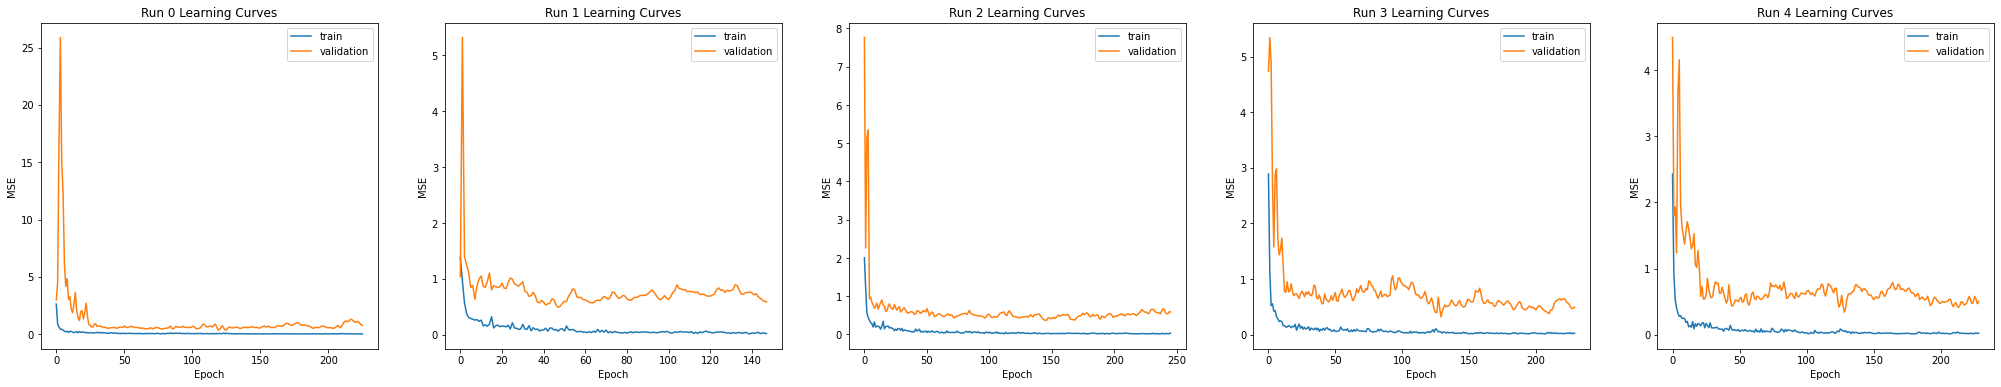

In [ ]:
improved = improve_n(df, n_steps = 6, n_val = 12, n_test = 12, 
              epochs = 5000, 
              normalize = True, 
              dropout = 0, 
              batch_norm = True,
              early_stop = True, 
              patience = 100,
              n_runs = 5,
              learning_rate = 0.01,
              test_score = True)

improved

* The performance doesn't differ too much from the validation set, so our model is good.

## 1.3 Building a multi-step model

* The model from the tutorial is a single-step model (it tries to predict the following time point, one month to the future). Try to do a multi-step model with a **6 months training window and predict the next 3 months (in the future).**

* In order to do this model, one can predict the n+1 month with n months windows model and then use the prediction to feed the n+1 window model to predict n+2 and so on:
    * 1) predict month 7 with 6 month window
    * 2) predit month 8 with 7 month window using previous prediction
    * 3) predict month 9 with 8 month windows using the 2 previous predictions
    * 4) evaluate the model on the whole 3 predictions knowing that the error propagated since the first prediction


In [ ]:
# split a univariate sequence into samples
def split_sequence_multi(sequence, n_steps, n_months):
    '''
    function to get the n_months after the split
    '''
    X, y = list(), list()
    
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        
        # check if we are beyond the sequence
        if end_ix + n_months > len(sequence)-1:
            break
            
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix: end_ix + n_months]
        
        X.append(seq_x)
        y.append(seq_y)
        
    return asarray(X), asarray(y)


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler


def predict_3(df, n_steps, val_split, n_test, 
              epochs = 50000, 
              normalize = False, 
              dropout = 0, 
              batch_norm = False,
              early_stop = False, 
              patience = 20,
              n_runs = 5,
              learning_rate = 0.001):
    '''
    Function to perform n_time runs of the RNN and provide the metrics
    
    inputs:
    df (pandas.DataFrame): dataframe
    n_step (int): number of monthsto consider for training
    val_split (int): number of months to consider for the validation set
    n_test (int): number of months to consider for the test set
    epochs (int): number of max epochs
    normalize (bool): whether to apply normalization to the data before starting the training process
    dropout (int): [0,1] fraction of the input units to drop from the previous layer to avoid overfitting
    batch_norm (bool): whether to apply bath normalization
    early_stop (bool): whether to apply early stop call back or not
    patience (int):  number of epochs to observed overfitting before taking action. Only considered if early_stop = True
    n_runs (int): number of runs for the average and standard deviation calculations
    '''
    
    
    # retrieve the values
    values = df.values.astype('float32')

    # if normalize:
    #     values = StandardScaler().fit_transform(pd.DataFrame(values))
    #     values = np.concatenate(values)

    # split into samples with 1 2 or 3 months after that to get the y_true
    X, y = split_sequence_multi(values, n_steps, 1) 
    _, y2 =split_sequence_multi(values, n_steps, 2)
    _, y3 =split_sequence_multi(values, n_steps, 3)

    # reshape into [samples, timesteps, features]
    X = X.reshape((X.shape[0], X.shape[1], 1))

    # split into train/test    
    X_train, X_test, y_train, y_test = X[:-n_test], X[-n_test:], y[:-n_test], y[-n_test:]
    
    y2_train, y2_test = y2[:-n_test], y2[-n_test:]
    y3_train, y3_test = y3[:-n_test], y3[-n_test:]
    
    y2_test = y2_test[:-1]
    y3_test = y3_test[:-2]
    
    if normalize:
        print('Normalization stats:\n Mean:',X_train.mean(),'Std_dev',X_train.std())
        X_mean = X_train.mean()
        X_std = X_train.std()

        X_train = (X_train - X_mean) / X_std
        X_test = (X_test - X_mean) / X_std

        y_train = (y_train - X_mean) / X_std
        y_test = (y_test - X_mean) / X_std

        y2_train = (y2_train - X_mean) / X_std
        y2_test = (y2_test - X_mean) / X_std

        y3_train = (y3_train - X_mean) / X_std
        y3_test = (y3_test - X_mean) / X_std
    
    # configure early stopping
    es = EarlyStopping(monitor='val_loss', patience=patience)
    
    fig, axes = plt.subplots(3, n_runs, figsize=(7*n_runs, 20) )
    
     
    results = pd.DataFrame(columns=['run','month','epochs','MSE', 'RMSE', 'MAE'])
    
    ax = 0
    for run in range(n_runs):
        
        
        X_train_ = X_train.copy()
        X_test_ = X_test.copy()
        y_train_ = y_train.copy()
        n_steps_ = n_steps
            
        for month in range(1,4):
            
            print(f'run {run+1}\tmonth {month}')


            # define model
            model = Sequential()
            model.add(LSTM(100, activation='relu', kernel_initializer='he_normal', input_shape=(n_steps_,1)))

            if dropout != 0:
                model.add(Dropout(dropout))

            if batch_norm:
                model.add(BatchNormalization())

            model.add(Dense(50, activation='relu', kernel_initializer='he_normal'))

            if dropout != 0:
                model.add(Dropout(dropout))

            if batch_norm:
                model.add(BatchNormalization())  

            model.add(Dense(50, activation='relu', kernel_initializer='he_normal'))

            model.add(Dense(1))

            #compile the model
            optimizer = Adam(lr=learning_rate)
            model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

            # fit the model         
            if early_stop:
                history = model.fit(X_train_, y_train_, epochs=epochs, batch_size=32, verbose=0, 
                                    validation_split=val_split, callbacks=[es])
            else:
                history = model.fit(X_train_, y_train_, epochs=epochs, batch_size=32, verbose=0, 
                                    validation_split=val_split)


            y_pred_train = model.predict(X_train_)

            # update X_train_
            
            X_train_ = np.concatenate((X_train_, y_pred_train.reshape((y_pred_train.shape[0], y_pred_train.shape[1], 1)) ) , axis=1)
            
            #remove last array
            X_train_ = X_train_[:-1]
            
            # increment n_steps
            n_steps_ += 1

            # evaluate the model and update y_train_
            if month ==1:
                mse, mae = model.evaluate(X_test_, y_test, verbose=0)
                y_train_ = y2_train
            if month ==2:
                mse, mae = model.evaluate(X_test_, y2_test, verbose=0)
                y_train_ = y3_train
            if month ==3:
                mse, mae = model.evaluate(X_test_, y3_test, verbose=0)

            # update X_test_
            y_pred_test = model.predict(X_test_)
            X_test_ = np.concatenate((X_test_, y_pred_test.reshape((y_pred_test.shape[0], y_pred_test.shape[1], 1)) ) , axis=1)
            X_test_ = X_test_[:-1]
            
            results = results.append( pd.DataFrame([[run, month,len(history.history['loss']),
                                                     mse ,
                                                     sqrt(mse), 
                                                     mae]], columns = results.columns))

            # plot learning curves
            axes.flat[ax].set_title(f'Run {run} month {month} Curves')
            axes.flat[ax].set_xlabel('Epoch')
            axes.flat[ax].set_ylabel('MSE')
            axes.flat[ax].plot(history.history['loss'], label='train')
            axes.flat[ax].plot(history.history['val_loss'], label='val')
            axes.flat[ax].legend()

            ax += 1


        #results = results.reset_index().rename({'index':'run'},axis=1)

        results = results.append( pd.DataFrame([[run,'mean',np.mean(results.epochs),
                                                 np.mean(results.MSE) ,
                                                 np.mean(results.RMSE) , 
                                                 np.mean(results.MAE)]], columns = results.columns))

        results = results.append( pd.DataFrame([[run, 'std', np.std(results.epochs),
                                                 np.std(results.MSE) ,
                                                 np.std(results.RMSE) , 
                                                 np.std(results.MAE)]], columns = results.columns)).reset_index(drop=True)
        

    r = results.style.apply(lambda row: ['background: lightgreen' if (set(['mean','std']).intersection(row.values)) 
                                  else '' for i in row], axis=1)
    display(r)
    
    # dataframe with avregares and std for each step and mean os means
    resul = pd.DataFrame(columns=['month','epochs_avg','RMSE_avg','MAE_avg','epochs_std','RMSE_std', 'MAE_std'])
    
    for m in range(1,4):
        resul = resul.append( pd.DataFrame([[m, 
                               np.mean(results.loc[results['month']==m, 'epochs']),
                               np.mean(results.loc[results['month']==m, 'RMSE']),
                               np.mean(results.loc[results['month']==m, 'MAE']),
                               np.std(results.loc[results['month']==m, 'epochs']),
                               np.std(results.loc[results['month']==m, 'RMSE']),
                               np.std(results.loc[results['month']==m, 'MAE'])
                              ]], 
                             columns = resul.columns ))
        
        
    resul = resul.append( pd.DataFrame([['total', 
                               np.mean( results.loc[(results['month']!='mean')&(results['month']!='std'), 'epochs']),
                               np.mean(results.loc[(results['month']!='mean')&(results['month']!='std'), 'RMSE']),
                               np.mean(results.loc[(results['month']!='mean')&(results['month']!='std'), 'MAE']),
                               np.std(results.loc[(results['month']!='mean')&(results['month']!='std'), 'epochs']),
                               np.std(results.loc[(results['month']!='mean')&(results['month']!='std'), 'RMSE']),
                               np.std(results.loc[(results['month']!='mean')&(results['month']!='std'), 'MAE'])
                              ]], 
                             columns = resul.columns ))
    
#     resul = resul.append(pd.DataFrame([['mean', 
#                                np.mean(resul['epochs_avg']),
#                                np.mean(resul['RMSE_avg']),
#                                np.mean(resul['MAE_avg']),
#                                np.nan,
#                                np.nan,
#                                np.nan
#                               ]], 
#                              columns = resul.columns ))
    
#     resul = resul.append(pd.DataFrame([['std', 
#                                np.std(resul['epochs_avg']),
#                                np.std(resul['RMSE_avg']),
#                                np.std(resul['MAE_avg']),
#                                np.nan,
#                                np.nan,
#                                np.nan
#                               ]], 
#                              columns = resul.columns ))
    
    r2 = resul.reset_index(drop=True).style.apply(lambda row: ['background: lightgreen' if (set(['total']).intersection(row.values)) 
                               else '' for i in row], axis=1)
    print('\n\n--- TOTAL ---')
    display(r2)
        
    return resul

run 1	month 1
run 1	month 2
run 1	month 3
run 2	month 1
run 2	month 2
run 2	month 3
run 3	month 1
run 3	month 2
run 3	month 3
run 4	month 1
run 4	month 2
run 4	month 3
run 5	month 1
run 5	month 2
run 5	month 3


,run,month,epochs,MSE,RMSE,MAE
0,0,1,350,5548778.000000,2355.584429,2028.593750
1,0,2,350,18862146.000000,4343.057218,3818.949951
2,0,3,350,41768864.000000,6462.883567,5640.851562
3,0,mean,350.000000,22059929.333333,4387.175071,3829.465088
4,0,std,0.000000,12954594.187914,1452.400830,1277.142230
5,1,1,350,8273430.000000,2876.357071,2509.289795
6,1,2,350,17127666.000000,4138.558445,3604.712402
7,1,3,350,26214986.000000,5120.057226,4223.756836
8,1,mean,306.250000,19101299.190156,3892.009232,3366.595202
9,1,std,109.131674,10087530.879326,1413.064297,1214.430611




--- TOTAL ---


,month,epochs_avg,RMSE_avg,MAE_avg,epochs_std,RMSE_std,MAE_std
0,1,350.000000,2804.907137,2400.827100,0.000000,449.500892,325.506637
1,2,350.000000,4025.901627,3443.092090,0.000000,562.989776,462.576797
2,3,350.000000,5601.726566,4698.934668,0.000000,683.389698,738.149664
3,total,350.000000,4144.178443,3514.284619,0.000000,1280.379317,1082.135012


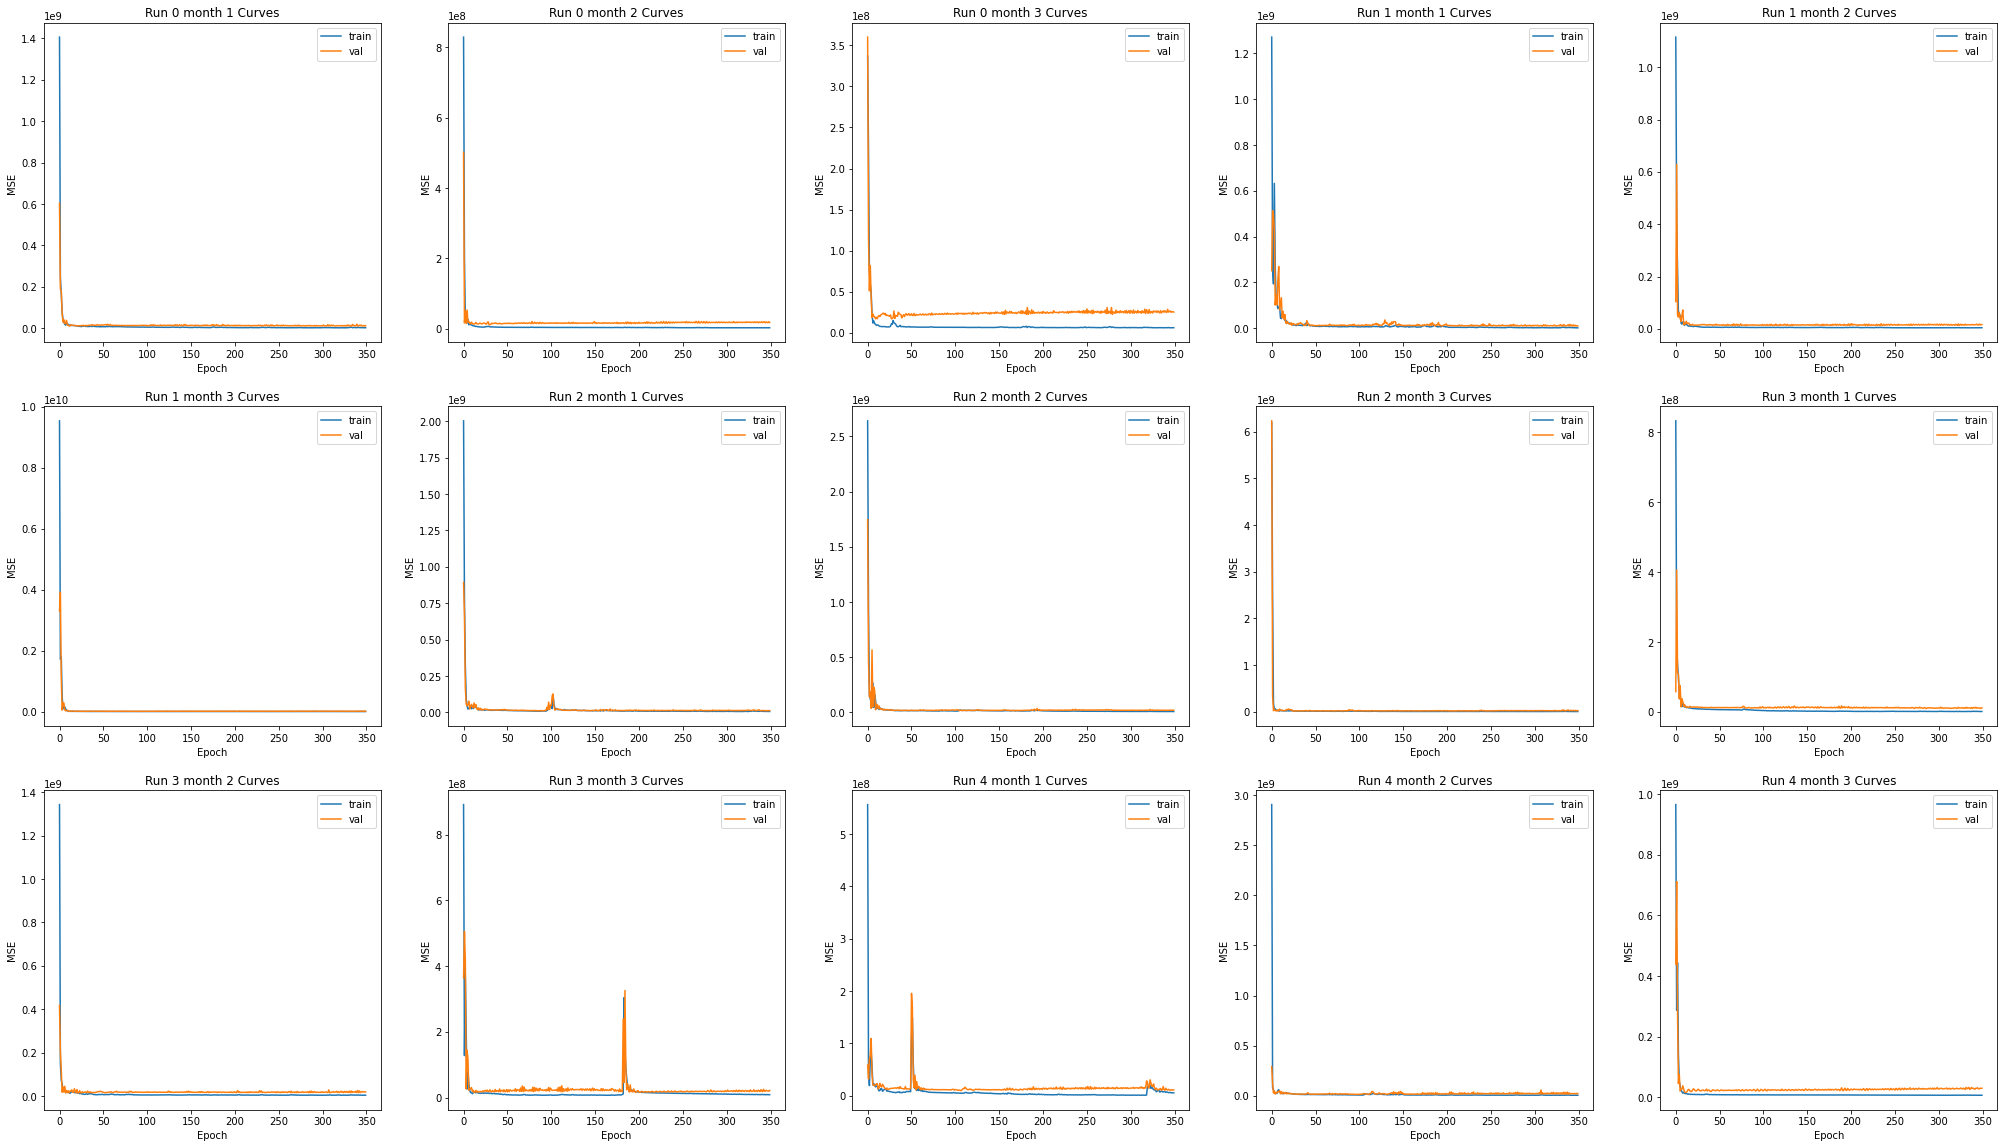

In [ ]:
std_3_steps = predict_3(df, n_steps = 6, val_split = 0.3, n_test = 12, 
              epochs = 350, 
              normalize = False, 
              dropout = 0, 
              batch_norm = False,
              early_stop = False, 
              patience = 20,
              n_runs = 5,
              learning_rate = 0.01)

**Take-Aways:**

* Curiously, Batchnorm or normalization did not improved results for this multi-step model.
* It was possible to create a model that predicts the next 3 months based on the previous data and predictions
* The model performs surprisingly well
* No overfitting was observed, in general, except for some runs that could really use some more epochs
* Lets try with early stop and more epochs to see if we can improve it

run 1	month 1
run 1	month 2
run 1	month 3
run 2	month 1
run 2	month 2
run 2	month 3
run 3	month 1
run 3	month 2
run 3	month 3
run 4	month 1
run 4	month 2
run 4	month 3
run 5	month 1
run 5	month 2
run 5	month 3


,run,month,epochs,MSE,RMSE,MAE
0,0,1,48,12366245.000000,3516.567218,2951.491943
1,0,2,40,8323776.000000,2885.095492,2050.093506
2,0,3,48,10661955.000000,3265.264920,2245.229736
3,0,mean,45.333333,10450658.666667,3222.309210,2415.605062
4,0,std,3.265986,1435073.780220,224.803281,335.336100
5,1,1,65,14632471.000000,3825.241300,3149.330811
6,1,2,41,11786650.000000,3433.169090,2845.880615
7,1,3,48,12014141.000000,3466.142092,2715.181152
8,1,mean,42.324915,10208871.305861,2979.824075,2338.518616
9,1,std,15.465339,3508208.360106,1010.183647,784.787158




--- TOTAL ---


,month,epochs_avg,RMSE_avg,MAE_avg,epochs_std,RMSE_std,MAE_std
0,1,62.400000,3737.071131,2988.524707,18.810635,138.973969,84.686579
1,2,56.000000,3155.654814,2520.701025,16.272676,257.460078,295.354898
2,3,51.200000,3825.213472,2880.681152,8.471127,572.162824,523.890519
3,total,56.533333,3572.646472,2796.635628,15.848729,475.281444,403.688239


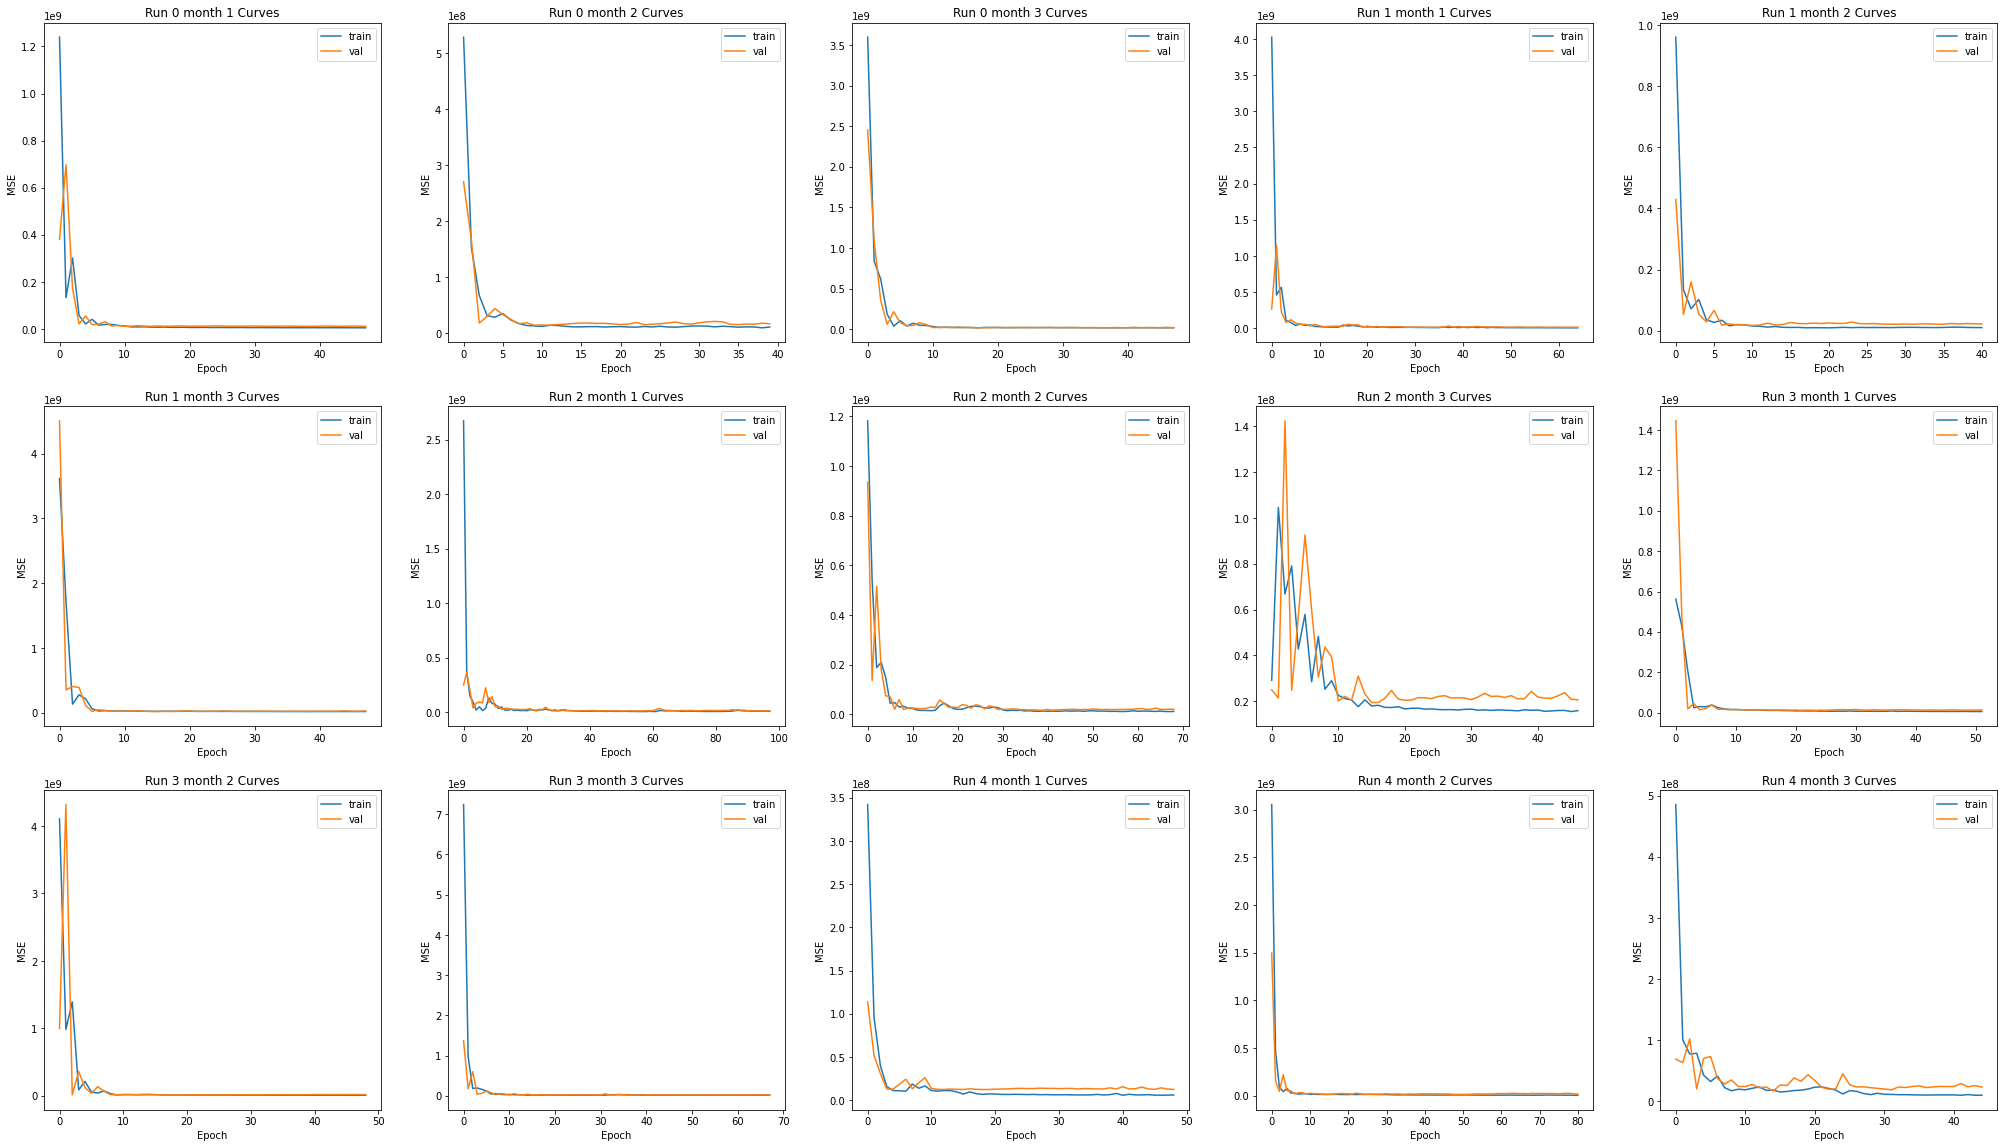

In [ ]:
std_3_steps_es = predict_3(df, n_steps = 6, val_split = 0.3, n_test = 12, 
              epochs = 5000, 
              normalize = False, 
              dropout = 0, 
              batch_norm = False,
              early_stop = True, 
              patience = 30,
              n_runs = 5,
              learning_rate = 0.01)

**Take-Aways:**

* The model performed slightly better
* The number of epochs was considerably low, and actually lower than expected given the patience